In [1]:
import pandas as pd
from notebooks.consts import *

In [2]:
csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

In [3]:
from notebooks.notebook_utils import log_correction, get_unique_human_genes

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan)  # to avoid log 0

In [4]:
genes_u = get_unique_human_genes(all_data_no_nan)

In [5]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

In [6]:
from tauso.new_model.data_handling import get_populated_df_with_structure_features

# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']

# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

all_data_human_gene = get_populated_df_with_structure_features(all_data_human_gene, genes_u, gene_to_data)

In [7]:
from tauso.data import get_data_dir
import os

def load_halflife_mapping():
    """
    Loads the TTDB data using the tauso directory structure.
    Returns a dictionary: {(Gene_Symbol, Cell_Line): Half_Life_Hours}
    """
    data_dir = get_data_dir()
    path = os.path.join(data_dir, 'mrna_half_life.csv.gz')

    print(f"Loading half-life data from {path}...")

    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found at {path}. Run 'tauso setup-mrna-halflife' first.")

    # 2. Load only necessary columns
    df = pd.read_csv(path, compression='gzip', usecols=['gene_name_x', 'cell_type', 'half_life'])

    # 3. Rename for clarity
    df = df.rename(columns={
        'gene_name_x': 'gene',
        'cell_type': 'cell_line'
    })

    # 4. Numerical Cleaning
    df['half_life'] = pd.to_numeric(df['half_life'], errors='coerce')
    df = df.dropna(subset=['gene', 'half_life'])
    df = df[df['half_life'] > 0]

    # 5. Clip Artifacts (Consistency Fix)
    df['half_life'] = df['half_life'].clip(upper=48.0)

    # 6. String Normalization
    df['gene'] = df['gene'].str.upper().str.strip()
    df['cell_line'] = df['cell_line'].str.strip()

    # 7. Handle Duplicates using GEOMETRIC MEAN
    # FIX: Pandas doesn't have .gmean(), so we use .apply()
    df_clean = df.groupby(['gene', 'cell_line'])['half_life'].apply(gmean)

    # 8. Convert to Dictionary
    mapping = df_clean.to_dict()

    print(f"Successfully loaded {len(mapping)} specific (Gene+Cell) stability profiles.")
    return mapping

In [8]:
from scipy.stats import gmean
import numpy as np
import pandas as pd

class HalfLifeOracle:
    def __init__(self, mapping):
        self.exact_map = mapping

        # Convert mapping (dict) back to DataFrame for easier tier-level aggregation
        # Mapping structure: {(Gene, Cell): Half_Life}
        df_map = pd.DataFrame(
            [{'gene': k[0], 'cell': k[1], 'hl': v} for k, v in mapping.items()]
        )

        # --- Tier 2 (Gene Stats) ---
        # Paper: "Geometric mean of that clipped gene’s half-life across all available cell-lines"

        # We group by gene and aggregate using gmean (and std/count for metadata)
        # Note: We use ddof=1 for std dev to estimate sample standard deviation
        gene_stats_df = df_map.groupby('gene')['hl'].agg(
            geom_mean=gmean,
            count='count',
            std='std'
        )
        # Convert to dict for O(1) lookup: gene -> {stats}
        self.gene_stats = gene_stats_df.to_dict(orient='index')

        # --- Tier 3 (Global Fallback) ---
        # Paper: "Global geometric mean of the clipped dataset"
        all_values = df_map['hl'].values

        if len(all_values) > 0:
            self.global_val = gmean(all_values)
            self.global_std = np.std(all_values, ddof=1)
        else:
            self.global_val = 0.0
            self.global_std = 0.0

        self.global_count = len(all_values)

        print(f"Oracle ready. Global Geometric Mean: {self.global_val:.2f}h (N={self.global_count})")

    def get_halflife(self, gene, cell_line):
        """
        Retrieves half-life with hierarchical fallback.
        """
        g = str(gene).upper().strip()
        c = str(cell_line).strip()

        # Tier 1: Exact Match (Specific Measurement)
        if (g, c) in self.exact_map:
            return self.exact_map[(g, c)], "Experimental (Specific)", 1, 0.0

        # Tier 2: Gene Estimate (Gene-Level)
        if g in self.gene_stats:
            stats = self.gene_stats[g]
            # RETURNING GEOMETRIC MEAN NOW
            return stats['geom_mean'], "Imputed (Gene GeomMean)", int(stats['count']), stats['std']

        # Tier 3: Global Baseline
        return self.global_val, "Imputed (Global GeomMean)", 0, self.global_std

In [9]:
# 1. Load the data (Run once)
mapping = load_halflife_mapping()
oracle = HalfLifeOracle(mapping)

Loading half-life data from /home/michael/.local/share/tauso/mrna_half_life.csv.gz...
Successfully loaded 517376 specific (Gene+Cell) stability profiles.
Oracle ready. Global Geometric Mean: 6.01h (N=517376)


In [13]:
# --- 1. Define the Mapping Strategy (The "Smart" Layer) ---
# This links your specific cell lines to the best biological match in TTDB.
cell_line_mapping = {
    # Direct / Strong Matches
    'HepG2': 'HepG2',
    'HepaRG': 'HepG2',          # Liver -> Liver
    'SNU-449': 'HepG2',         # Liver -> Liver
    'Hela': 'Hela',

    # Neuronal Mappings
    'Human IPS': 'iPSN',        # iPSC-Neurons -> iPSN
    'Human Neuronal Cell': 'iPSN',
    'PAC neurons asyn': 'neuron',
    'SH-SY5Y': 'neural precursor cells',
    'Angptl2/Actin': 'neural precursor cells', # Assumed SK-N-AS
    'SK cells asyn': 'neural precursor cells',
    'U251': 'neural precursor cells', # Glioblastoma -> NPC proxy

    # Skin / Epithelial
    'A431': 'N/TERT-1 keratinocytes',
    'SK-MEL-28': 'N/TERT-1 keratinocytes',

    # Blood / Immune
    'H929': 'K562',             # Myeloma -> Leukemia proxy
    'KMS11': 'K562',
    'MM.1R': 'K562',
    'KARPAS-229': 'T cells',    # Lymphoma -> T cells

    # Other Tissue
    'NCI-H460': 'MRC5VA',       # Lung Cancer -> Lung Fibroblast proxy
    'CC-2580': 'MRC5VA',        # Muscle -> Fibroblast proxy
}

# --- 2. Your Data Input (Cleaned) ---
# Removed 'Oscillation' and 'Tubulin' as they appear to be controls, not cells.
cell_line_to_gene = {
    'A431': ['KRAS', 'MALAT1', 'SOD1', 'APOL1', 'IRF5'],
    'Angptl2/Actin': ['ANGPTL2'],
    'CC-2580': ['MYH7'],
    'H929': ['IRF4'],
    'Hela': ['HIF1A'],
    'HepG2': ['HBV', 'SOD1', 'DGAT2'],
    'HepaRG': ['KLKB1', 'HSD17B13'],
    'Human IPS': ['SNCA'],
    'Human Neuronal Cell': ['SNHG14', 'UBE3A', 'HBII-52'],
    'KARPAS-229': ['IRF5'],
    'KMS11': ['IRF4'],
    # 'LLC-MK2 monkey': ['SNCA'], # Note: TTDB is human, this will likely hit Gene Average fallback
    'MM.1R': ['IRF4'],
    # 'Mouse Primary Neuronal Cell': ['SNHG14', 'UBE3A'], # Note: Mouse cells will hit fallback
    'NCI-H460': ['KRAS'],
    'PAC neurons asyn': ['SNCA'],
    'SH-SY5Y': ['SNCA', 'SOD1'],
    'SK cells asyn': ['SNCA'],
    'SK-MEL-28': ['IRF4'],
    'SNU-449': ['YAP1'],
    'U251': ['HTRA1'],
}

# --- 3. Execution Loop ---
data_rows = []

for original_cell, genes in cell_line_to_gene.items():
    # Step A: Find the best TTDB proxy.
    # If not in map, keep original name (which will likely trigger Oracle fallback)
    proxy_cell = cell_line_mapping.get(original_cell, original_cell)

    for gene in genes:
        # Step B: Query Oracle using the PROXY name
        hl_val, source, n, std = oracle.get_halflife(gene, proxy_cell)

        # Clip artifacts
        hl_final = min(hl_val, 48.0)

        data_rows.append({
            "Target_Gene": gene,
            "Original_Cell_Line": original_cell, # Keep track of your label
            "Mapped_TTDB_Proxy": proxy_cell,     # Keep track of what we used
            "Half_Life": hl_final,
            "HL_Source": source,
            "HL_N_Support": n,
            "HL_StdDev": std
        })

df_halflife = pd.DataFrame(data_rows)

# Display results to verify mapping worked
print(df_halflife[['Target_Gene', 'Original_Cell_Line', 'Mapped_TTDB_Proxy', 'Half_Life', 'HL_Source']].head(50))

   Target_Gene           Original_Cell_Line            Mapped_TTDB_Proxy  \
0         KRAS                         A431       N/TERT-1 keratinocytes   
1       MALAT1                         A431       N/TERT-1 keratinocytes   
2         SOD1                         A431       N/TERT-1 keratinocytes   
3        APOL1                         A431       N/TERT-1 keratinocytes   
4         IRF5                         A431       N/TERT-1 keratinocytes   
5      ANGPTL2                Angptl2/Actin       neural precursor cells   
6         MYH7                      CC-2580                       MRC5VA   
7         IRF4                         H929                         K562   
8        HIF1A                         Hela                         Hela   
9          HBV                        HepG2                        HepG2   
10        SOD1                        HepG2                        HepG2   
11       DGAT2                        HepG2                        HepG2   
12       KLK

In [21]:
from notebooks.features.feature_extraction import save_feature


# --- 1. Define the Logic for the Full Dataset ---
def get_halflife_features(row):
    """
    Calculates mRNA half-life and maps the cell line proxy for a single row.
    """
    # Use your constants for column names
    gene = row[CANONICAL_GENE]
    cell = row[CELL_LINE] # or CELL_LINE_ID depending on your consts

    # A. Map to TTDB Proxy
    # Uses the 'cell_line_mapping' dict we defined earlier
    proxy_cell = cell_line_mapping.get(cell, cell)

    # B. Manual Override (e.g. HBV)
    # Check for specific cases like the virus we discussed
    if gene == 'HBV' and cell == 'HepG2':
        return pd.Series([6.1, 'Literature (HepG2 pgRNA)', proxy_cell],
                         index=['mRNA_HalfLife', 'HalfLife_Source', 'Mapped_Cell_Proxy'])

    # C. Query the Oracle
    hl_val, source, n, std = oracle.get_halflife(gene, proxy_cell)

    # D. Clip Artifacts (Standardize max duration)
    hl_final = min(hl_val, 48.0)

    # Return the three columns you asked for
    return pd.Series([hl_final, source, proxy_cell],
                     index=['mRNA_HalfLife', 'HalfLife_Source', 'Mapped_Cell_Proxy'])

# --- 2. Apply to Main DataFrame ---
print(f"Calculating stability features for {len(all_data_human_gene)} rows...")

# Apply the function row-by-row
# This creates a new dataframe with just the 3 new columns
features_df = all_data_human_gene.apply(get_halflife_features, axis=1)

# --- 3. Merge and Update ---
# Concatenate the new columns to your main dataframe
# We use axis=1 to add them as columns matching the index
all_data_human_gene = pd.concat([all_data_human_gene, features_df], axis=1)

print("Merge complete. New columns added: 'mRNA_HalfLife', 'Mapped_Cell_Proxy'")

save_feature(all_data_human_gene, "mRNA_HalfLife")
save_feature(all_data_human_gene, "Mapped_Cell_Proxy")
print("SUCCESS: Features saved via save_feature().")

Calculating stability features for 31000 rows...
Merge complete. New columns added: 'mRNA_HalfLife', 'Mapped_Cell_Proxy'
SUCCESS: Features saved via save_feature().


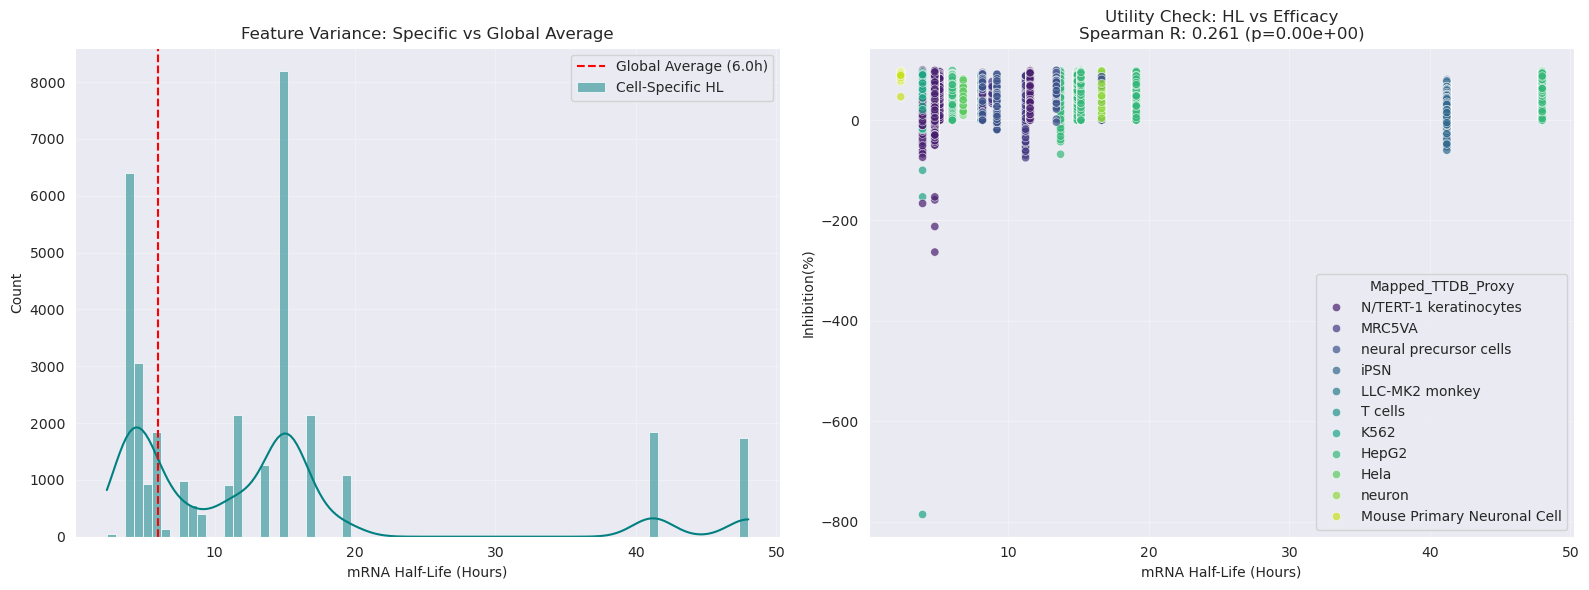

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# --- Step 1: Prepare the Data ---
# We need to merge the calculated half-lives back into your main experimental data
# Assuming 'all_data' has columns: 'Target_Gene', 'Cell_Line_Name', 'Inhibition'
# And 'df_halflife' has: 'Target_Gene', 'Original_Cell_Line', 'Half_Life'

# Ensure names match for merging
df_halflife_merge = df_halflife.rename(columns={'Original_Cell_Line': 'Cell_Line_ID'})

# Merge only on the specific Gene+Cell pairs we calculated
merged_df = pd.merge(
    all_data, # Your main dataset with inhibition scores
    df_halflife_merge[['Target_Gene', 'Cell_Line_ID', 'Half_Life', 'Mapped_TTDB_Proxy']],
    left_on=[CANONICAL_GENE, CELL_LINE], # Adjust column names to match your data
    right_on=['Target_Gene', 'Cell_Line_ID'],
    how='inner'
)

# --- Step 2: Visualization ---
plt.figure(figsize=(16, 6))

# GRAPH A: Information Gain (Specific vs Global)
# Did the mapping actually give us new numbers?
plt.subplot(1, 2, 1)
global_avg = 6.01 # The global geometric mean we found earlier
sns.histplot(merged_df['Half_Life'], kde=True, color='teal', label='Cell-Specific HL')
plt.axvline(global_avg, color='red', linestyle='--', label='Global Average (6.0h)')
plt.title("Feature Variance: Specific vs Global Average")
plt.xlabel("mRNA Half-Life (Hours)")
plt.legend()
plt.grid(True, alpha=0.3)

# GRAPH B: Utility (Correlation with Inhibition)
# Does stability actually affect how well the ASO works?
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=merged_df,
    x='Half_Life',
    y=INHIBITION, # Replace with your actual efficacy column name
    hue='Mapped_TTDB_Proxy',
    alpha=0.7,
    palette='viridis'
)

# Calculate Correlation
corr, p_val = spearmanr(merged_df['Half_Life'], merged_df[INHIBITION])
plt.title(f"Utility Check: HL vs Efficacy\nSpearman R: {corr:.3f} (p={p_val:.2e})")
plt.xlabel("mRNA Half-Life (Hours)")
plt.ylabel(INHIBITION)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()